In [1]:
import gc
import torch
import shap
import numpy as np
import pandas as pd
from transformers import AutoConfig, BertTokenizer
from transformers.models.bert.modeling_bert import BertEmbeddings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from load_model import *

# Testing baseline model with BERT Embedding

## Load data

In [2]:
df = pd.read_csv('./data/train.csv')
X = df['text']
Y = df['suicide']

## Pre-processing

### WordVectorization with Bert Embedding

In [3]:
X = [sen for sen in X]

labels = Y.values

### Tokenize

In [4]:
# get pre-trained tokenizer model
tokenizer = BertTokenizer.from_pretrained('./pretrained/bert-base-uncased')

tokenizer

BertTokenizer(name_or_path='./pretrained/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [5]:
max_length = 512

tokenized = tokenizer(X, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

sen_ids = tokenized['input_ids']

print(sen_ids.size())

torch.Size([185650, 512])


### Word embedding

In [6]:
config = AutoConfig.from_pretrained('./pretrained/bert-base-uncased')
config.hidden_size = 8
bert_embedding = BertEmbeddings(config)

bert_embedding

BertEmbeddings(
  (word_embeddings): Embedding(30522, 8, padding_idx=0)
  (position_embeddings): Embedding(512, 8)
  (token_type_embeddings): Embedding(2, 8)
  (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [7]:
embedded = bert_embedding(sen_ids)

In [8]:
embedded = embedded.view(len(embedded), -1)

embedded.size()

torch.Size([185650, 4096])

In [9]:
del tokenized
del sen_ids
del X
del Y
del df

gc.collect()

33

## Building the baseline model

For testing purposes, we will use the Logistic Regression classifier `LogisticRegression()` with its default settings as our baseline model.

In [10]:
clf = LogisticRegression(max_iter=10000)

## Evaluating the Baseline Model

### 5-fold Stratified Cross-validation

In [11]:
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=60)
accuracy_score_list, recall_score_list, precision_score_list, f1_score_list = [], [], [], []

for time, (train_index, test_index) in enumerate(skfolds.split(embedded, labels)):
    X_train, X_test = embedded[train_index].detach().numpy(), embedded[test_index].detach().numpy()
    Y_train, Y_test = labels[train_index], labels[test_index]

    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    print(clf.n_iter_)

    # Evaluate model
    AccuracyScore = accuracy_score(Y_test, y_pred)
    RecallScore = recall_score(Y_test, y_pred)
    PrecisionScore = precision_score(Y_test, y_pred)
    F1Score = f1_score(Y_test, y_pred)

    # Add to lists
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)

    # Print the matrix
    print('Time: ', time + 1)
    print('\taccuracy_score: ', AccuracyScore)
    print('\trecall_score: ', RecallScore)
    print('\tprecision_score: ', PrecisionScore)
    print('\tf1_score: ', F1Score)

[1836]
Time:  1
	accuracy_score:  0.7337462967950444
	recall_score:  0.6991164745178321
	precision_score:  0.7510707257784466
	f1_score:  0.7241629464285714
[1903]
Time:  2
	accuracy_score:  0.7331268516024778
	recall_score:  0.6994935890529038
	precision_score:  0.7498700548657233
	f1_score:  0.7238063383226021
[1680]
Time:  3
	accuracy_score:  0.736089415566927
	recall_score:  0.705042560068958
	precision_score:  0.7516512549537648
	f1_score:  0.727601256497929
[1469]
Time:  4
	accuracy_score:  0.7322650148128198
	recall_score:  0.69863161297274
	precision_score:  0.7489460005775339
	f1_score:  0.7229144019845584
[1597]
Time:  5
	accuracy_score:  0.7318610288176677
	recall_score:  0.6985238659627195
	precision_score:  0.7483550733002424
	f1_score:  0.7225813642443156


In [12]:
# Print the average value of each matrix
print("Accuracy: {:.2%}".format(np.average(accuracy_score_list)))
print("Recall: {:.2%}".format(np.average(recall_score_list)))
print("Precision: {:.2%}".format(np.average(precision_score_list)))
print("F1_score: {:.2%}".format(np.average(f1_score_list)))

Accuracy: 73.34%
Recall: 70.02%
Precision: 75.00%
F1_score: 72.42%


## Save the model

In [13]:
import pickle

clf.fit(embedded.detach().numpy(), labels)
print(clf.n_iter_)

with open('./model/LR_bert.pickle', 'wb') as f:
    pickle.dump(clf, f)

[1952]


In [37]:
torch.save(bert_embedding, './model/embedding.pth')

using code below to load the fitted model:

``` python
with open('./model/LR_bert.pickle', 'rb') as f:
    clf = pickle.load(f)
```

## Test Model

### Load data

In [14]:
df = pd.read_csv('./data/test.csv')
X = df['text']
Y = df['suicide']

X = [sen for sen in X]
labels = Y.values

In [15]:
tokenized = tokenizer(X, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

sen_ids = tokenized['input_ids']

embedded = bert_embedding(sen_ids)

embedded = embedded.view(len(embedded), -1)

embedded.size()

x_test = embedded.detach().numpy()

### Confusion Metric

<Figure size 640x480 with 0 Axes>

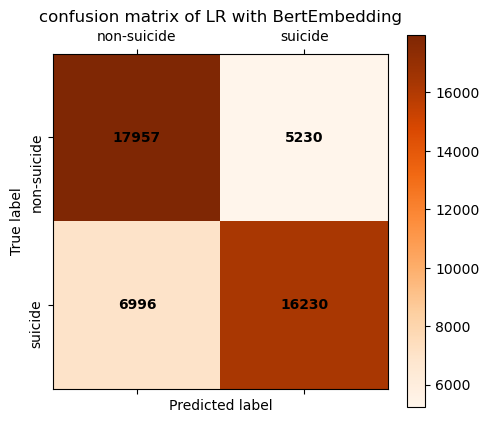

              precision    recall  f1-score   support

           0       0.72      0.77      0.75     23187
           1       0.76      0.70      0.73     23226

    accuracy                           0.74     46413
   macro avg       0.74      0.74      0.74     46413
weighted avg       0.74      0.74      0.74     46413



In [16]:
lrb_preds = clf.predict_proba(x_test)
y_pred = lrb_preds.argmax(1)
cm = confusion_matrix(labels, y_pred)
plt.figure()
plt.matshow(cm, cmap=plt.cm.Oranges)
plt.colorbar(fraction=0.05)
for x in range(len(cm)):
    for y in range(len(cm)):
        plt.annotate(cm[x, y], xy=(y, x), horizontalalignment='center', verticalalignment='center', weight='heavy')

plt.xlabel('Predicted label')
plt.xticks([1, 0], ['suicide', 'non-suicide'])
plt.ylabel('True label')
plt.yticks([1, 0], ['suicide', 'non-suicide'], rotation=90)
plt.title('confusion matrix of LR with BertEmbedding')
plt.savefig('./img/cm_LR_B.jpg')
plt.show()

print(classification_report(labels, y_pred))

### ROC Curve

In [17]:
fpr, tpr, _ = roc_curve(labels, lrb_preds[:, 1])
roc_auc = auc(fpr, tpr)

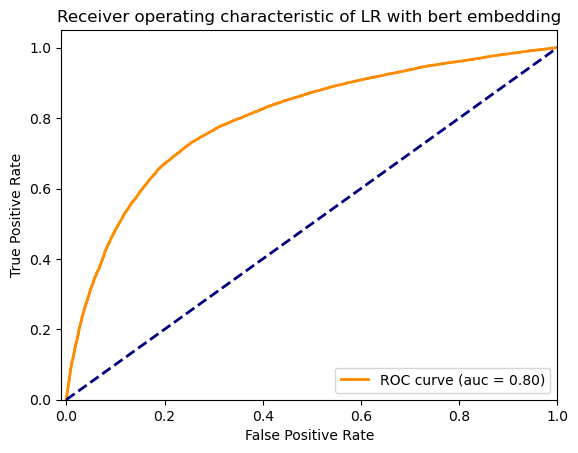

In [18]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of LR with bert embedding')
plt.legend(loc="lower right")
plt.savefig('./img/roc_LR_b.jpg')
plt.show()

### Compare with LSTM

In [19]:
LSTM_tokenizer = BertTokenizer.from_pretrained('./pretrained/bert-base-uncased')
max_length = 512

tokenized = LSTM_tokenizer(X, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

sen_ids = tokenized['input_ids']

In [20]:
def predict(lstm_model, ids):
    lstm_pred_list = []

    lstm_model.eval()
    with torch.no_grad():
        for i in range(len(ids)):
            hidden = lstm_model.init_hidden(1)
            X = ids[i].unsqueeze(dim=0).cuda()
            
            lstm_pred, _ = lstm_model(X, hidden)

            lstm_pred = lstm_pred.cpu().numpy()
            lstm_pred_list.append(lstm_pred.tolist())

    return lstm_pred_list

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lstm_path = './model/LSTM_classifier.pt'
lstm_model = load_LSTMClassifier(lstm_path, device)

In [22]:
lstm_preds = predict(lstm_model, sen_ids)

lstm_preds = np.array(lstm_preds).reshape(-1, 2)

In [23]:
lstm_fpr, lstm_tpr, _ = roc_curve(labels, lstm_preds[:, 1])
lstm_roc_auc = auc(lstm_fpr, lstm_tpr)

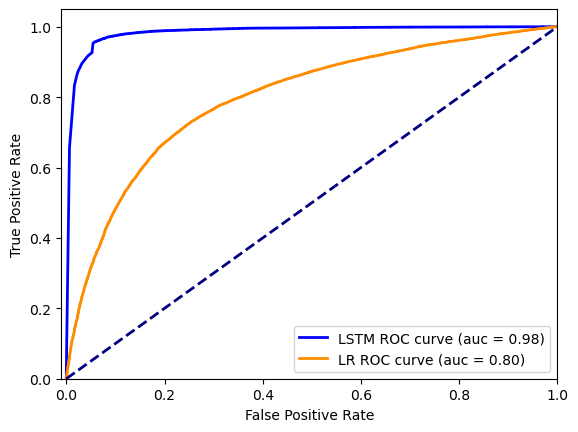

In [24]:
plt.figure()
plt.plot(lstm_fpr, lstm_tpr, color='blue',
         lw=lw, label='LSTM ROC curve (auc = %0.2f)' % lstm_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='LR ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('./img/roc_LRb&LSTM.jpg')
plt.show()

## XAI

In [25]:
fps = []
fns = []

for i in range(len(labels)):
    if y_pred[i] != labels[i]:
        if y_pred[i] == 1:
            fps.append(X[i])
        else:
            fns.append(X[i])

In [32]:
def LR_B_f(x):
    tv = torch.tensor([tokenizer.encode(v, padding="max_length", max_length=512, truncation=True) for v in x])
    tv = bert_embedding(tv)
    tv = tv.view(len(tv), -1).detach().numpy()
    outputs = clf.predict_proba(tv)
    return outputs

In [33]:
explainer = shap.Explainer(LR_B_f, tokenizer, output_names=['non-suicide', 'suicide'])

In [34]:
sv = explainer(fps[: 2])
shap.plots.text(sv)

In [35]:
sv = explainer(fns[: 2])
shap.plots.text(sv)